#Install packages and load libraries

Install non-native packages



In [1]:
%%capture
!pip install scikit-learn==0.22.2.post1
!pip install ipynb

Import common packages

In [2]:
import cProfile
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle, pstats, sys
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, average_precision_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import KFold, train_test_split

Enable Google Colab, mount drives, and load proprietary modules...

In [3]:
%%capture
from google.colab import drive, files
drive.mount('/content/drive', force_remount=False)
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/Primary Research/JLMwSCBC_notebook/code/code_toPublish')   
import ppiPrediction_v2
import dataProcessing
import modelTraining
import modelEvaluating                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

#Define file paths and key variables

In [ ]:
global dateSignature
dateSignature = datetime.datetime.now().strftime("%Y-%m-%d")

#directories
workDir = '/content/drive/My Drive/Colab Notebooks/Primary Research/JLMwSCBC_notebook/'
LMprotein_complexesDir = workDir + 'proteinComplexes/Lugo-Martinez/'
GWprotein_complexesDir = workDir + 'proteinComplexes/Drew_LM_Wilkins/'

##Functions

In [ ]:
def getIntersecting_rows(targetDataFrame, intersectDataFrame_0, *intersectDataFrames_additional, returnMatching_indices=False):
    targetDataFrame_intersection = targetDataFrame.merge(intersectDataFrame_0, how='inner', on=['label', 'prot1', 'prot2'], indicator=True)
    targetDataFrame_intersection = targetDataFrame_intersection.loc[targetDataFrame_intersection._merge=='both']
    print(targetDataFrame_intersection.shape)
    targetDataFrame_intersection.drop(columns=['_merge'], inplace=True)

    if intersectDataFrames_additional:
        for intersectingDF in intersectDataFrames_additional:
            targetDataFrame_intersectionN = targetDataFrame_intersection.merge(intersectingDF, how='inner', on=['label', 'prot1', 'prot2'], indicator=True)
            targetDataFrame_intersectionN = targetDataFrame_intersectionN.loc[targetDataFrame_intersectionN._merge=='both']
            print(targetDataFrame_intersectionN.shape)
            targetDataFrame_intersectionN.drop(columns=['_merge'], inplace=True)
            targetDataFrame_intersection = targetDataFrame_intersectionN

    if returnMatching_indices:
        ppiIndices_targetDataFrame = targetDataFrame.merge(targetDataFrame_intersection, how='left', on=['label', 'prot1', 'prot2'], indicator=True)
        ppiIndices_targetDataFrame = ppiIndices_targetDataFrame.loc[ppiIndices_targetDataFrame._merge=='both']
        print(ppiIndices_targetDataFrame.shape)
        print(ppiIndices_targetDataFrame.head())
        ppiIndices_targetDataFrame = list(ppiIndices_targetDataFrame.index)

        return targetDataFrame_intersection, ppiIndices_targetDataFrame

    else:

        return targetDataFrame_intersection

In [ ]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

In [ ]:
def findFraction_overlap(table, maxPPIs):

  newTable = table.copy()
  for i in np.arange(table.shape[0]):
    for j in np.arange(table.shape[1]):
      newTable[i, j] = table[i, j]/maxPPIs

  return newTable

#Unit-Accuracy and Combined-Weight Performance with Cell-Type Specific NCI-60 Features and HPA Consensus Features

In [ ]:
testData = pd.read_csv(LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_test_either_model.tsv', sep='\t')
testData.shape

(546645, 268)

In [ ]:
trainData_testing.head()

,Wan_1,Wan_2,Wan_3,Wan_4,Wan_5,Wan_6,Wan_7,Wan_8,Wan_9,Wan_10,Wan_11,Wan_12,Wan_13,Wan_14,Wan_15,Wan_16,Wan_17,Wan_18,Wan_19,Wan_20,Wan_21,Wan_22,Wan_23,Wan_24,Wan_25,Wan_26,Wan_27,Wan_28,Wan_29,Wan_30,Wan_31,Wan_32,Wan_33,Wan_34,Wan_35,Wan_36,Wan_37,Wan_38,Wan_39,Wan_40,...,Wan_229,Wan_230,Wan_231,Wan_232,Wan_233,Wan_234,Wan_235,Wan_236,Wan_237,Wan_238,Wan_239,Wan_240,Wan_241,BioPlex_1,BioPlex_2,BioPlex_3,BioPlex_4,BioPlex_5,BioPlex_6,BioPlex_7,BioPlex_8,BioPlex_9,BioPlex_MM_1,BioPlex_MM_2,BioPlex_our_1,BioPlex_our_2,Hein_1,Hein_2,Hein_3,Hein_4,Hein_MM_1,Hein_MM_2,Hein_our_1,Hein_our_2,NCI_prot_abun,NCI_RNA_exp,HPA_SwissProt_1,HPA_SwissProt_2,HPA_SwissProt_3,HPA_SwissProt_4
0,0.0,0.0,0.0,0.0,0.000924,0.057159,0.0,-0.064575,0.0,0.0,0.0,-0.237305,0.0,0.0,0.0,0.0,0.13855,0.352295,0.0,0.272949,0.009911,0.338135,0.0,-0.036224,-0.017471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.010437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000908,-0.001066,0.429036,-0.000669,0.0,0.0,0.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.089418,-0.170990,0.0,0.0,0.0,1.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000835,0.000098,0.009156,-0.020434,1.0,0.0,0.5,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004290,-0.001430,NaN,NaN,NaN,NaN,NaN,NaN,-0.000314,NaN,-0.019563,0.044276,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.473698,1.0,NaN,-0.000204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000305,-0.016391,0.158370,0.0,0.0,0.0,1.0


In [ ]:
trainData_testing = pd.read_csv(LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_training_either_model(orig).tsv', sep='\t')
trainData_testing.shape

(491524, 268)

In [ ]:
labelsAgnostic = pd.read_csv(LMprotein_complexesDir + 'integrated_test_labels_either_model.tsv', sep='\t')
labelsAgnostic.shape

(546645, 3)

In [ ]:
trainLabels_testing.head()

,0,1,2
0,1,8467,6878
1,1,65993,28973
2,1,6125,9045
3,1,55173,54460
4,1,7153,9188


In [ ]:
#expName='ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures'
#modelsEval_properties = pd.read_csv(workDir + 'modelPerformance/modelsPerformance_{0}/agnostic/'.format(expName) + 'Partition-Classifier_Testing_Performance.csv')
candidatePartitions = np.loadtxt(workDir + 'modelPerformance/modelsPerformance_{0}/agnostic/'.format(expName) + 'candidatePartitions.csv', delimiter=',')
candidatePartitions_preds = np.loadtxt(workDir + 'modelPerformance/modelsPerformance_{0}/agnostic/'.format(expName) + 'candidatePartitions_preds.csv', delimiter=',')
candidatePartitions_predsProbs = np.loadtxt(workDir + 'modelPerformance/modelsPerformance_{0}/agnostic/'.format(expName) + 'candidatePartitions_predsProbs.csv', delimiter=',')

print(modelsEval_properties.shape)
print(candidatePartitions.shape)
print(candidatePartitions_preds.shape)
print(candidatePartitions_predsProbs.shape)

(263, 9)
(546645, 263)
(546645, 263)
(546645, 263)


In [ ]:
candidatePartitions = candidatePartitions[labelsAgnostic_indices, :]
candidatePartitions_preds = candidatePartitions_preds[labelsAgnostic_indices, :]
candidatePartitions_predsProbs = candidatePartitions_predsProbs[labelsAgnostic_indices, :]

print(candidatePartitions.shape)
print(candidatePartitions_preds.shape)
print(candidatePartitions_predsProbs.shape)

(301356, 263)
(301356, 263)
(301356, 263)


In [ ]:
groundTruth_intersection.shape

(301356, 3)

In [ ]:
probsPos_acc, probsPos_weighted, testLabels_adj = \
    modelEvaluating.evalTotal(candidatePartitions, candidatePartitions_predsProbs,
                              modelsEval_properties, groundTruth_intersection, workDir, expName)

precAcc, recAcc, precWeighted, recWeighted = modelEvaluating.evalSummary(probsPos_acc, probsPos_weighted,
                                                                          testLabels_adj, workDir, expName)

Streaming output truncated to the last 5000 lines.
progress: 0.983444829371242
progress: 0.9834481477057035
progress: 0.9834514660401651
progress: 0.9834547843746266
progress: 0.9834581027090883
progress: 0.9834614210435498
progress: 0.9834647393780114
progress: 0.9834680577124729
progress: 0.9834713760469346
progress: 0.9834746943813961
progress: 0.9834780127158577
progress: 0.9834813310503192
progress: 0.9834846493847808
progress: 0.9834879677192424
progress: 0.983491286053704
progress: 0.9834946043881655
progress: 0.983497922722627
progress: 0.9835012410570886
progress: 0.9835045593915502
progress: 0.9835078777260118
progress: 0.9835111960604733
progress: 0.9835145143949349
progress: 0.9835178327293964
progress: 0.9835211510638581
progress: 0.9835244693983196
progress: 0.9835277877327812
progress: 0.9835311060672427
progress: 0.9835344244017042
progress: 0.9835377427361659
progress: 0.9835410610706274
progress: 0.983544379405089
progress: 0.9835476977395505
progress: 0.9835510160740

In [ ]:
#get models and evaluate
precAcc, recAcc, precWeighted, recWeighted = ppiPrediction_v2.run(workDir, 
                                                                  LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_training_either_model_LC:NCI_H322M-cell-line_specific+HPAconsensus.tsv', 
                                                                  LMprotein_complexesDir + 'integrated_training_labels_either_model_cell-line-specific_wHPAconsensus.tsv', 
                                                                  LMprotein_complexesDir + 'testData_h322mSpecific_nci60Feats_h322_mcf7_u251_pairsIntersection.tsv', 
                                                                  LMprotein_complexesDir + 'integrated_test_labels_either_model__groundTruth_U251-MCF7-H322-Intersection.tsv', 
                                                                  expName='ppiPrediction_performanceAnalysis_integratedFeatures_H322M-Cell-Type-Specific',
                                                                  hasHeadings=True) 

In [ ]:
#get models and evaluate
precAcc, recAcc, precWeighted, recWeighted = ppiPrediction_v2.run(workDir, 
                                                                  LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_training_either_model_BR:MCF7-cell-line_specific+HPAconsensus.tsv', 
                                                                  LMprotein_complexesDir + 'integrated_training_labels_either_model_cell-line-specific_wHPAconsensus.tsv', 
                                                                  LMprotein_complexesDir + 'testData_mcf7Specific_nci60Feats_h322_mcf7_u251_pairsIntersection.tsv', 
                                                                  LMprotein_complexesDir + 'integrated_test_labels_either_model__groundTruth_U251-MCF7-H322-Intersection.tsv', 
                                                                  expName='ppiPrediction_performanceAnalysis_integratedFeatures_MCF7-Cell-Type-Specific',
                                                                  hasHeadings=True) 

In [ ]:
#get models and evaluate
precAcc, recAcc, precWeighted, recWeighted = ppiPrediction_v2.run(workDir, 
                                                                  LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_training_either_model_CNS:U251-cell-line_specific+HPAconsensus.tsv', 
                                                                  LMprotein_complexesDir + 'integrated_training_labels_either_model_cell-line-specific_wHPAconsensus.tsv', 
                                                                  LMprotein_complexesDir + 'testData_u251Specific_nci60Feats_h322_mcf7_u251_pairsIntersection.tsv', 
                                                                  LMprotein_complexesDir + 'integrated_test_labels_either_model__groundTruth_U251-MCF7-H322-Intersection.tsv', 
                                                                  expName='ppiPrediction_performanceAnalysis_integratedFeatures_U251-Cell-Type-Specific',
                                                                  hasHeadings=True) 

#Assess differences in predictions

##Find intersection of available pairs across all cell-type specific evaluations

In [ ]:
groundTruth_intersection, labelsAgnostic_indices = getIntersecting_rows(labelsAgnostic, labelsU251, labelsMCF7, labelsH322M, returnMatching_indices=True)

(519224, 4)
(507341, 4)
(301356, 4)
(301356, 4)
    label  prot1  prot2 _merge
1       1  65993  28973   both
6       1   6203   6188   both
9       1   8189   1478   both
11      1  84844  10262   both
12      1   9045   6135   both


In [ ]:
labelsAgnostic = pd.read_csv(LMprotein_complexesDir + 'integrated_test_labels_either_model.tsv', sep='\t')
labelsAgnostic = labelsAgnostic.rename(columns={'0': 'label', '1': 'prot1', '2': 'prot2'})
print(labelsAgnostic.shape)
print(labelsAgnostic.head())

(546645, 3)
   label  prot1  prot2
0      1   8467   6878
1      1  65993  28973
2      1   6125   9045
3      1  55173  54460
4      1   7153   9188


In [ ]:
labelsU251 = pd.read_csv(LMprotein_complexesDir + 'integrated_test_labels_either_model__U251.tsv', sep='\t')
print(labelsU251.shape)
print(labelsU251.head())

(519224, 3)
   label  prot1  prot2
0      1   8467   6878
1      1  65993  28973
2      1  55173  54460
3      1   7153   9188
4      1  22794  65109


In [ ]:
labelsMCF7 = pd.read_csv(LMprotein_complexesDir + 'integrated_test_labels_either_model__MCF7.tsv', sep='\t')
print(labelsMCF7.shape)
print(labelsMCF7.head())

(515644, 3)
   label  prot1  prot2
0      1   8467   6878
1      1  65993  28973
2      1  55173  54460
3      1   7153   9188
4      1  22794  65109


In [ ]:
labelsH322M = pd.read_csv(LMprotein_complexesDir + 'integrated_test_labels_either_model__H322M.tsv', sep='\t')
labelsH322M.drop(columns=['NCI_RNA_exp', 'NCI_prot_abun'], inplace=True)
labelsH322M = labelsH322M[['label', 'prot1', 'prot2']]
print(labelsH322M.shape)
print(labelsH322M.head())

(304074, 3)
   label  prot1  prot2
0      1  65993  28973
1      1   6203   6188
2      1   8189   1478
3      1  84844  10262
4      1   9045   6135


In [ ]:
groundTruth_intersection, labelsAgnostic_indices = getIntersecting_rows(labelsAgnostic, labelsU251, labelsMCF7, labelsH322M, returnMatching_indices=True)

(519224, 4)
(507341, 4)
(301356, 4)
(301356, 4)
    label  prot1  prot2 _merge
1       1  65993  28973   both
6       1   6203   6188   both
9       1   8189   1478   both
11      1  84844  10262   both
12      1   9045   6135   both


In [ ]:
indices_h322m_origDF = labelsAgnostic.merge(labelsH322M, how='left', on=['label', 'prot1', 'prot2'], indicator=True)
indices_h322m_origDF = indices_h322m_origDF.loc[indices_h322m_origDF._merge=='both']
indices_h322m_origDF = list(indices_h322m_origDF.index)
len(indices_h322m_origDF)

304074

In [ ]:
indices_mcf7_origDF = labelsAgnostic.merge(labelsMCF7, how='left', on=['label', 'prot1', 'prot2'], indicator=True)
indices_mcf7_origDF = indices_mcf7_origDF.loc[indices_mcf7_origDF._merge=='both']
indices_mcf7_origDF = list(indices_mcf7_origDF.index)
len(indices_mcf7_origDF)

515644

In [ ]:
indices_u251_origDF = labelsAgnostic.merge(labelsU251, how='left', on=['label', 'prot1', 'prot2'], indicator=True)
indices_u251_origDF = indices_u251_origDF.loc[indices_u251_origDF._merge=='both']
indices_u251_origDF = list(indices_u251_origDF.index)
len(indices_u251_origDF)

519224

In [ ]:
_, labelsU251_indices = getIntersecting_rows(labelsU251, groundTruth_intersection, returnMatching_indices=True)

(301356, 4)
(301356, 4)
    label  prot1  prot2 _merge
1       1  65993  28973   both
5       1   6203   6188   both
7       1   8189   1478   both
9       1  84844  10262   both
10      1   9045   6135   both


In [ ]:
_, labelsMCF7_indices = getIntersecting_rows(labelsMCF7, groundTruth_intersection, returnMatching_indices=True)

(301356, 4)
(301356, 4)
    label  prot1  prot2 _merge
1       1  65993  28973   both
5       1   6203   6188   both
8       1   8189   1478   both
10      1  84844  10262   both
11      1   9045   6135   both


In [ ]:
_, labelsH322M_indices = getIntersecting_rows(labelsH322M, groundTruth_intersection, returnMatching_indices=True)

(301356, 4)
(301356, 4)
   label  prot1  prot2 _merge
0      1  65993  28973   both
1      1   6203   6188   both
2      1   8189   1478   both
3      1  84844  10262   both
4      1   9045   6135   both


In [ ]:
groundTruth_intersection = pd.read_csv(LMprotein_complexesDir + 'integrated_test_labels_either_model__groundTruth_U251-MCF7-H322-Intersection.tsv', sep='\t')
groundTruth_intersection.shape

(301356, 3)

In [ ]:
LM_testData = pd.read_csv(LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_test_either_model(orig).tsv', sep='\t')

In [ ]:
LM_testData_U251_MCF7_H322_intersection = LM_testData.loc[labelsAgnostic_indices, :]
LM_testData_U251_MCF7_H322_intersection.shape

(301356, 268)

In [ ]:
LM_testData_U251_MCF7_H322_intersection.to_csv(LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_test_either_model(orig)_H322+MCF7+U251_cellSpecific_availablePairs_intersection.tsv', index=False)

In [ ]:
_, labelsU251_indices = getIntersecting_rows(labelsU251, groundTruth_intersection, returnMatching_indices=True)

(301356, 4)
(301356, 4)
    label  prot1  prot2 _merge
1       1  65993  28973   both
5       1   6203   6188   both
7       1   8189   1478   both
9       1  84844  10262   both
10      1   9045   6135   both


In [ ]:
labelsU251_indices

In [ ]:
_, labelsMCF7_indices = getIntersecting_rows(labelsMCF7, groundTruth_intersection, returnMatching_indices=True)

(301356, 4)
(301356, 4)
    label  prot1  prot2 _merge
1       1  65993  28973   both
5       1   6203   6188   both
8       1   8189   1478   both
10      1  84844  10262   both
11      1   9045   6135   both


In [ ]:
_, labelsH322M_indices = getIntersecting_rows(labelsH322M, groundTruth_intersection, returnMatching_indices=True)

(301356, 4)
(301356, 4)
   label  prot1  prot2 _merge
0      1  65993  28973   both
1      1   6203   6188   both
2      1   8189   1478   both
3      1  84844  10262   both
4      1   9045   6135   both


In [ ]:
trainingData_h322mSpecific_nci60Feats_h322_mcf7_u251_pairsIntersection = trainingData_h322mSpecific_nci60Feats.loc[labelsH322M_indices, :]
trainingData_mcf7Specific_nci60Feats_h322_mcf7_u251_pairsIntersection = trainingData_mcf7Specific_nci60Feats.loc[labelsMCF7_indices, :]
trainingData_u251Specific_nci60Feats_h322_mcf7_u251_pairsIntersection = trainingData_u251Specific_nci60Feats.loc[labelsU251_indices, :]

print(trainingData_h322mSpecific_nci60Feats_h322_mcf7_u251_pairsIntersection.shape)
print(trainingData_mcf7Specific_nci60Feats_h322_mcf7_u251_pairsIntersection.shape)
print(trainingData_u251Specific_nci60Feats_h322_mcf7_u251_pairsIntersection.shape)

(301356, 268)
(301356, 268)
(301356, 268)


In [ ]:
trainingData_h322mSpecific_nci60Feats_h322_mcf7_u251_pairsIntersection.to_csv(LMprotein_complexesDir + 'testData_h322mSpecific_nci60Feats_h322_mcf7_u251_pairsIntersection.tsv', sep='\t', index=False)
trainingData_mcf7Specific_nci60Feats_h322_mcf7_u251_pairsIntersection.to_csv(LMprotein_complexesDir + 'testData_mcf7Specific_nci60Feats_h322_mcf7_u251_pairsIntersection.tsv', sep='\t', index=False)
trainingData_u251Specific_nci60Feats_h322_mcf7_u251_pairsIntersection.to_csv(LMprotein_complexesDir + 'testData_u251Specific_nci60Feats_h322_mcf7_u251_pairsIntersection.tsv', sep='\t', index=False)

##Compare performances for same pairs across cell type agnostic and cell-type specific trained models

In [ ]:
performances4Comparision = [[workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/agnostic/unit-accuracy_results.csv', 'Consensus']]
precRecall_pairs0 = []
for cmpPerformance in performances4Comparision:
    precRecall_pairs0.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))

In [ ]:
performances4Comparision = [
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/h322m/unit-accuracy_results.csv', 'H322M'],
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/mcf7/unit-accuracy_results.csv', 'MCF7'],
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/u251/unit-accuracy_results.csv', 'U251']
]
precRecall_pairs1 = []
for cmpPerformance in performances4Comparision:
    precRecall_pairs1.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))

In [ ]:
performances4Comparision = [
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_integratedFeatures_H322M-Cell-Type-Specific/unit-accuracy_results.csv', 'H322M'],
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_integratedFeatures_MCF7-Cell-Type-Specific/unit-accuracy_results.csv', 'MCF7'],
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_integratedFeatures_U251-Cell-Type-Specific/unit-accuracy_results.csv', 'U251']
]
precRecall_pairs2 = []
for cmpPerformance in performances4Comparision:
    precRecall_pairs2.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))

In [ ]:
performances4Comparision = [[workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/agnostic/combined-weighted_results.csv', 'Consensus']]
precRecall_pairs3 = []
for cmpPerformance in performances4Comparision:
    precRecall_pairs3.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))

In [ ]:
performances4Comparision = [
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/h322m/combined-weighted_results.csv', 'H322M'], 
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/mcf7/combined-weighted_results.csv', 'MCF7'],
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/u251/combined-weighted_results.csv', 'U251']
]
precRecall_pairs4 = []
for cmpPerformance in performances4Comparision:
    precRecall_pairs4.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))

In [ ]:
performances4Comparision = [
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_integratedFeatures_H322M-Cell-Type-Specific/combined-weighted_results.csv', 'H322M'],
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_integratedFeatures_MCF7-Cell-Type-Specific/combined-weighted_results.csv', 'MCF7'],
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_integratedFeatures_U251-Cell-Type-Specific/combined-weighted_results.csv', 'U251']
]
precRecall_pairs5 = []
for cmpPerformance in performances4Comparision:
    precRecall_pairs5.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))

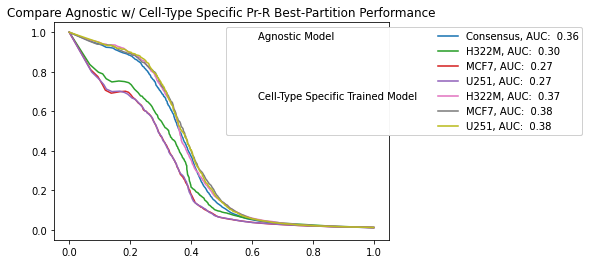

In [ ]:
filename1 = 'Cmp_Agnostic+H322M+MCF7+U251_Best-Partition_Pr-R_Performance'
plt.clf()
plt.title('Compare Agnostic w/ Cell-Type Specific Pr-R Best-Partition Performance')
categories = ['Agnostic Model', 'Cell-Type Specific Trained Model']

precRecall_auc = auc(precRecall_pairs0[0][0], precRecall_pairs0[0][1])
p0, = plt.plot(precRecall_pairs0[0][0], precRecall_pairs0[0][1], label=precRecall_pairs0[0][2] + ', AUC: {0: .2f}'.format(precRecall_auc))

pDA, = plt.plot([0], marker='None', linestyle='None', label='dummy-tophead')
precRecall_auc = auc(precRecall_pairs1[0][0], precRecall_pairs1[0][1])
p1, = plt.plot(precRecall_pairs1[0][0], precRecall_pairs1[0][1], label=precRecall_pairs1[0][2] + ', AUC: {0: .2f}'.format(precRecall_auc))
precRecall_auc = auc(precRecall_pairs1[1][0], precRecall_pairs1[1][1])
p2, = plt.plot(precRecall_pairs1[1][0], precRecall_pairs1[1][1], label=precRecall_pairs1[1][2] + ', AUC: {0: .2f}'.format(precRecall_auc))
precRecall_auc = auc(precRecall_pairs1[2][0], precRecall_pairs1[2][1])
p3, = plt.plot(precRecall_pairs1[2][0], precRecall_pairs1[2][1], label=precRecall_pairs1[2][2] + ', AUC: {0: .2f}'.format(precRecall_auc))

pDTr, = plt.plot([0], marker='None', linestyle='None', label='dummy-empty')
precRecall_auc = auc(precRecall_pairs2[0][0], precRecall_pairs2[0][1])
p4, = plt.plot(precRecall_pairs2[0][0], precRecall_pairs2[0][1], label=precRecall_pairs2[0][2] + ', AUC: {0: .2f}'.format(precRecall_auc))
precRecall_auc = auc(precRecall_pairs2[1][0], precRecall_pairs2[1][1])
p5, = plt.plot(precRecall_pairs2[1][0], precRecall_pairs2[1][1], label=precRecall_pairs2[1][2] + ', AUC: {0: .2f}'.format(precRecall_auc))
precRecall_auc = auc(precRecall_pairs2[2][0], precRecall_pairs2[2][1])
p6, = plt.plot(precRecall_pairs2[2][0], precRecall_pairs2[2][1], label=precRecall_pairs2[2][2] + ', AUC: {0: .2f}'.format(precRecall_auc))

leg = plt.legend([pDA, pDTr, pDA, pDTr, pDA, pDTr, pDA, p0, p1, p2, p3, p4, p5, p6],
              [categories[0], '', '', '', categories[1], '', ''] + 
              [p0.get_label(), p1.get_label(), p2.get_label(), p3.get_label()] + 
              [p4.get_label(), p5.get_label(), p6.get_label()],
              loc='upper left', ncol=2, bbox_to_anchor=(0.5, 1))

plt.gca().add_artist(leg)

plt.savefig(workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/' + filename1 + '.png', bbox_inches='tight')

In [ ]:
filename2 = 'Cmp_Agnostic+H322M+MCF7+U251_Weighted_Pr-R_Performance'

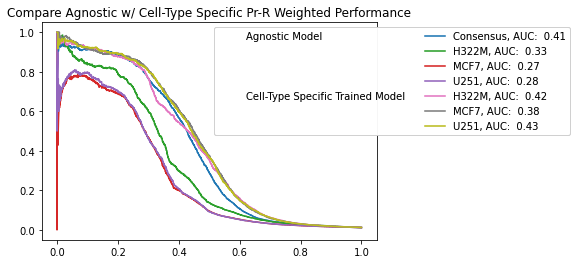

In [ ]:
plt.clf()
plt.title('Compare Agnostic w/ Cell-Type Specific Pr-R Weighted Performance')
categories = ['Agnostic Model', 'Cell-Type Specific Trained Model']

precRecall_auc = auc(precRecall_pairs3[0][0], precRecall_pairs3[0][1])
p0, = plt.plot(precRecall_pairs3[0][0], precRecall_pairs3[0][1], label=precRecall_pairs3[0][2] + ', AUC: {0: .2f}'.format(precRecall_auc))

pDA, = plt.plot([0], marker='None', linestyle='None', label='dummy-tophead')
precRecall_auc = auc(precRecall_pairs4[0][0], precRecall_pairs4[0][1])
p1, = plt.plot(precRecall_pairs4[0][0], precRecall_pairs4[0][1], label=precRecall_pairs4[0][2] + ', AUC: {0: .2f}'.format(precRecall_auc))
precRecall_auc = auc(precRecall_pairs4[1][0], precRecall_pairs4[1][1])
p2, = plt.plot(precRecall_pairs4[1][0], precRecall_pairs4[1][1], label=precRecall_pairs4[1][2] + ', AUC: {0: .2f}'.format(precRecall_auc))
precRecall_auc = auc(precRecall_pairs4[2][0], precRecall_pairs4[2][1])
p3, = plt.plot(precRecall_pairs4[2][0], precRecall_pairs4[2][1], label=precRecall_pairs4[2][2] + ', AUC: {0: .2f}'.format(precRecall_auc))

pDTr, = plt.plot([0], marker='None', linestyle='None', label='dummy-empty')
precRecall_auc = auc(precRecall_pairs5[0][0], precRecall_pairs5[0][1])
p4, = plt.plot(precRecall_pairs5[0][0], precRecall_pairs5[0][1], label=precRecall_pairs5[0][2] + ', AUC: {0: .2f}'.format(precRecall_auc))
precRecall_auc = auc(precRecall_pairs2[1][0], precRecall_pairs2[1][1])
p5, = plt.plot(precRecall_pairs5[1][0], precRecall_pairs5[1][1], label=precRecall_pairs5[1][2] + ', AUC: {0: .2f}'.format(precRecall_auc))
precRecall_auc = auc(precRecall_pairs5[2][0], precRecall_pairs5[2][1])
p6, = plt.plot(precRecall_pairs5[2][0], precRecall_pairs5[2][1], label=precRecall_pairs5[2][2] + ', AUC: {0: .2f}'.format(precRecall_auc))

leg = plt.legend([pDA, pDTr, pDA, pDTr, pDA, pDTr, pDA, p0, p1, p2, p3, p4, p5, p6],
              [categories[0], '', '', '', categories[1], '', ''] + 
              [p0.get_label(), p1.get_label(), p2.get_label(), p3.get_label()] + 
              [p4.get_label(), p5.get_label(), p6.get_label()],
              loc='upper left', ncol=2, bbox_to_anchor=(0.5, 1))

plt.gca().add_artist(leg)

plt.savefig(workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/' + filename2 + '.png', bbox_inches='tight')

##Cell-Type Agnostic Models

In [ ]:
dirsNames = ['agnostic', 'u251', 'mcf7', 'h322m']

dirsIndices = dict(zip(dirsNames, [labelsAgnostic_indices, labelsU251_indices, labelsMCF7_indices, labelsH322M_indices]))

predsAcc = dict(zip(dirsNames, []))
precisionAcc = dict(zip(dirsNames, []))
recallAcc = dict(zip(dirsNames, []))
thresholdsAcc = dict(zip(dirsNames, []))
meanDiff_acc = np.empty((groundTruth_intersection.shape[0], len(dirsNames)))
meanDiff_acc[:] = np.nan

predsWeighted = dict(zip(dirsNames, []))
precisionWeighted = dict(zip(dirsNames, []))
recallWeighted = dict(zip(dirsNames, []))
thresholdsWeighted = dict(zip(dirsNames, []))
meanDiff_weighted = np.empty((groundTruth_intersection.shape[0], len(dirsNames)))
meanDiff_weighted[:] = np.nan

In [ ]:
for dir in dirsNames:
  predictionsAcc = np.loadtxt(workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/{0}/probsPos_acc.csv'.format(dir), delimiter=',')
  predsAcc[dir] = predictionsAcc[dirsIndices[dir]]
  precisionAcc[dir], recallAcc[dir], thresholdsAcc[dir] = precision_recall_curve(groundTruth_intersection.label, predsAcc[dir])

  predictionsWeighted = np.loadtxt(workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/{0}/probsPos_weighted.csv'.format(dir), delimiter=',')
  predsWeighted[dir] = predictionsWeighted[dirsIndices[dir]]
  precisionWeighted[dir], recallWeighted[dir], thresholdsWeighted[dir] = precision_recall_curve(groundTruth_intersection.label, predsWeighted[dir])

In [ ]:
thresholds = np.arange(0, 1, 0.001)

for dir, i in zip(dirsNames, np.arange(len(dirsNames))):   
    fscore_acc = [f1_score(groundTruth_intersection.label, to_labels(predsAcc[dir], t)) for t in thresholds]
    ixAcc = np.nanargmax(fscore_acc)
    print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ixAcc], fscore_acc[ixAcc]))

    fscore_weighted = [f1_score(groundTruth_intersection.label, to_labels(predsWeighted[dir], t)) for t in thresholds]
    ixWeighted = np.nanargmax(fscore_weighted)
    print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ixWeighted], fscore_weighted[ixWeighted]))    

    ppiPreds_bestThres_acc = predsAcc[dir]
    ppiPreds_bestThres_acc[ppiPreds_bestThres_acc >= thresholds[ixAcc]] = 1
    ppiPreds_bestThres_acc[ppiPreds_bestThres_acc < thresholds[ixAcc]] = 0    
    meanDiff_acc[:, i] = ppiPreds_bestThres_acc

    ppiPreds_bestThres_weighted = predsWeighted[dir]
    ppiPreds_bestThres_weighted[ppiPreds_bestThres_weighted >= thresholds[ixWeighted]] = 1
    ppiPreds_bestThres_weighted[ppiPreds_bestThres_weighted < thresholds[ixWeighted]] = 0    
    meanDiff_weighted[:, i] = ppiPreds_bestThres_weighted

Threshold=0.671, F-Score=0.45311
Threshold=0.455, F-Score=0.48897
Threshold=0.906, F-Score=0.38415
Threshold=0.820, F-Score=0.38094
Threshold=0.906, F-Score=0.37754
Threshold=0.786, F-Score=0.37887
Threshold=0.873, F-Score=0.39729
Threshold=0.763, F-Score=0.40439


In [ ]:
meanDiff_acc = pd.DataFrame(meanDiff_acc, columns=dirsNames)
meanDiff_accOverlap = meanDiff_acc.loc[meanDiff_acc.sum(axis=1) > 0, :]
meanDiff_accOverlap_count = np.empty((len(dirsNames), len(dirsNames)))
meanDiff_accOverlap_count[:] = np.nan

meanDiff_weighted = pd.DataFrame(meanDiff_weighted, columns=dirsNames)
meanDiff_weightedOverlap = meanDiff_weighted.loc[meanDiff_weighted.sum(axis=1) > 0, :]
meanDiff_weightedOverlap_count = np.empty((len(dirsNames), len(dirsNames)))
meanDiff_weightedOverlap_count[:] = np.nan

In [ ]:
groundTruth_intersection.label.sum()

3757

In [ ]:
for x in np.arange(len(dirsNames)):
  for y in np.arange(len(dirsNames)):
    pair = np.array([x, y])
    pairOnesAcc = meanDiff_accOverlap.iloc[:, [x, y]].loc[(meanDiff_accOverlap.iloc[:, x]==1) & (meanDiff_accOverlap.iloc[:, y]==1)]
    meanDiff_accOverlap_count[x, y] = len(pairOnesAcc.loc[pairOnesAcc.iloc[:, 0]==pairOnesAcc.iloc[:, 1]])

    pairOnesWeighted = meanDiff_weightedOverlap.iloc[:, [x, y]].loc[(meanDiff_weightedOverlap.iloc[:, x]==1) & (meanDiff_weightedOverlap.iloc[:, y]==1)]
    meanDiff_weightedOverlap_count[x, y] = len(pairOnesWeighted.loc[pairOnesWeighted.iloc[:, 0]==pairOnesWeighted.iloc[:, 1]])

In [ ]:
meanDiff_accOverlap_count

array([[2118., 1455., 1464., 1534.],
       [1455., 2475., 2170., 1968.],
       [1464., 2170., 2547., 1991.],
       [1534., 1968., 1991., 2440.]])

In [ ]:
meanDiff_weightedOverlap_count

array([[2816., 1283., 1496., 1439.],
       [1283., 1845., 1618., 1370.],
       [1496., 1618., 2509., 1612.],
       [1439., 1370., 1612., 1985.]])

In [ ]:
meanDiff_accOverlap_frac = findFraction_overlap(meanDiff_accOverlap_count, 3757)
meanDiff_accOverlap_frac = pd.DataFrame(meanDiff_accOverlap_frac, columns=dirsNames)

meanDiff_weightedOverlap_frac=findFraction_overlap(meanDiff_weightedOverlap_count, 3757)
meanDiff_weightedOverlap_frac = pd.DataFrame(meanDiff_weightedOverlap_frac, columns=dirsNames)

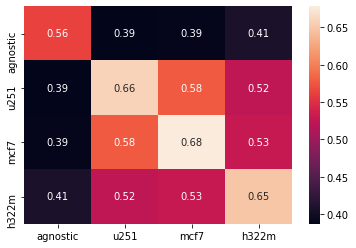

In [ ]:
plt.clf()
sns.heatmap(meanDiff_accOverlap_frac, 
        xticklabels=meanDiff_accOverlap_frac.columns,
        yticklabels=meanDiff_accOverlap_frac.columns,
        annot=True)
plt.savefig(workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/' + 'pPPIOverlap_bestPartition_agnosticModel+consensusHPA_cellSpecificPreds' + '.png', bbox_inches='tight')

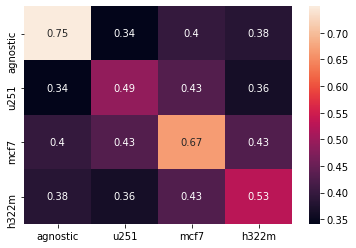

In [ ]:
plt.clf()
sns.heatmap(meanDiff_weightedOverlap_frac, 
        xticklabels=meanDiff_weightedOverlap_frac.columns,
        yticklabels=meanDiff_weightedOverlap_frac.columns,
        annot=True)
plt.savefig(workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/' + 'pPPIOverlap_weightedPartition_agnosticModel+consensusHPA_cellSpecificPreds' + '.png', bbox_inches='tight')

##Cell-Type Specific Models

In [ ]:
dirsNames = ['agnostic', 'u251', 'mcf7', 'h322m']
dirPaths = [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/agnostic/',
            workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_integratedFeatures_U251-Cell-Type-Specific/',
            workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_integratedFeatures_MCF7-Cell-Type-Specific/',
            workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_integratedFeatures_H322M-Cell-Type-Specific/',
            ]

predsAcc = dict(zip(dirsNames, []))
precisionAcc = dict(zip(dirsNames, []))
recallAcc = dict(zip(dirsNames, []))
thresholdsAcc = dict(zip(dirsNames, []))
meanDiff_acc = np.empty((groundTruth_intersection.shape[0], len(dirsNames)))
meanDiff_acc[:] = np.nan

predsWeighted = dict(zip(dirsNames, []))
precisionWeighted = dict(zip(dirsNames, []))
recallWeighted = dict(zip(dirsNames, []))
thresholdsWeighted = dict(zip(dirsNames, []))
meanDiff_weighted = np.empty((groundTruth_intersection.shape[0], len(dirsNames)))
meanDiff_weighted[:] = np.nan

In [ ]:
dir = 'agnostic'
dirsIndices = dict(zip(dirsNames, [labelsAgnostic_indices, labelsU251_indices, labelsMCF7_indices, labelsH322M_indices]))
predictionsAcc = np.loadtxt(workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/agnostic/probsPos_acc.csv', delimiter=',')
predsAcc[dir] = predictionsAcc[dirsIndices[dir]]
print(predsAcc[dir].shape)
precisionAcc[dir], recallAcc[dir], thresholdsAcc[dir] = precision_recall_curve(groundTruth_intersection.label, predsAcc[dir])

predictionsWeighted = np.loadtxt(workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/agnostic/probsPos_weighted.csv', delimiter=',')
predsWeighted[dir] = predictionsWeighted[dirsIndices[dir]]
print(predsWeighted[dir].shape)
precisionWeighted[dir], recallWeighted[dir], thresholdsWeighted[dir] = precision_recall_curve(groundTruth_intersection.label, predsWeighted[dir])

(301356,)
(301356,)


In [ ]:
for dir, path in zip(dirsNames[1:], dirPaths[1:]):
  predsAcc[dir] = np.loadtxt(path + 'probsPos_acc.csv', delimiter=',')
  print(predsAcc[dir].shape)
  precisionAcc[dir], recallAcc[dir], thresholdsAcc[dir] = precision_recall_curve(groundTruth_intersection.label, predsAcc[dir])

  predsWeighted[dir] = np.loadtxt(path + 'probsPos_weighted.csv', delimiter=',')
  print(predsWeighted[dir].shape)
  precisionWeighted[dir], recallWeighted[dir], thresholdsWeighted[dir] = precision_recall_curve(groundTruth_intersection.label, predsWeighted[dir])

(301356,)
(301356,)
(301356,)
(301356,)
(301356,)
(301356,)


In [ ]:
thresholds = np.arange(0, 1, 0.001)

for dir, i in zip(dirsNames, np.arange(len(dirsNames))):   
    fscore_acc = [f1_score(groundTruth_intersection.label, to_labels(predsAcc[dir], t)) for t in thresholds]
    ixAcc = np.nanargmax(fscore_acc)
    print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ixAcc], fscore_acc[ixAcc]))

    fscore_weighted = [f1_score(groundTruth_intersection.label, to_labels(predsWeighted[dir], t)) for t in thresholds]
    ixWeighted = np.nanargmax(fscore_weighted)
    print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ixWeighted], fscore_weighted[ixWeighted]))    

    ppiPreds_bestThres_acc = predsAcc[dir]
    ppiPreds_bestThres_acc[ppiPreds_bestThres_acc >= thresholds[ixAcc]] = 1
    ppiPreds_bestThres_acc[ppiPreds_bestThres_acc < thresholds[ixAcc]] = 0    
    meanDiff_acc[:, i] = ppiPreds_bestThres_acc

    ppiPreds_bestThres_weighted = predsWeighted[dir]
    ppiPreds_bestThres_weighted[ppiPreds_bestThres_weighted >= thresholds[ixWeighted]] = 1
    ppiPreds_bestThres_weighted[ppiPreds_bestThres_weighted < thresholds[ixWeighted]] = 0    
    meanDiff_weighted[:, i] = ppiPreds_bestThres_weighted

Threshold=0.671, F-Score=0.45311
Threshold=0.455, F-Score=0.48897
Threshold=0.703, F-Score=0.44103
Threshold=0.486, F-Score=0.48101
Threshold=0.718, F-Score=0.44402
Threshold=0.482, F-Score=0.48397
Threshold=0.713, F-Score=0.44203
Threshold=0.458, F-Score=0.46357


In [ ]:
meanDiff_acc = pd.DataFrame(meanDiff_acc, columns=dirsNames)
meanDiff_accOverlap = meanDiff_acc.loc[meanDiff_acc.sum(axis=1) > 0, :]
meanDiff_accOverlap_count = np.empty((len(dirsNames), len(dirsNames)))
meanDiff_accOverlap_count[:] = np.nan

meanDiff_weighted = pd.DataFrame(meanDiff_weighted, columns=dirsNames)
meanDiff_weightedOverlap = meanDiff_weighted.loc[meanDiff_weighted.sum(axis=1) > 0, :]
meanDiff_weightedOverlap_count = np.empty((len(dirsNames), len(dirsNames)))
meanDiff_weightedOverlap_count[:] = np.nan

In [ ]:
groundTruth_intersection.label.sum()

3757

In [ ]:
for x in np.arange(len(dirsNames)):
  for y in np.arange(len(dirsNames)):
    pair = np.array([x, y])
    pairOnesAcc = meanDiff_accOverlap.iloc[:, [x, y]].loc[(meanDiff_accOverlap.iloc[:, x]==1) & (meanDiff_accOverlap.iloc[:, y]==1)]
    meanDiff_accOverlap_count[x, y] = len(pairOnesAcc.loc[pairOnesAcc.iloc[:, 0]==pairOnesAcc.iloc[:, 1]])

    pairOnesWeighted = meanDiff_weightedOverlap.iloc[:, [x, y]].loc[(meanDiff_weightedOverlap.iloc[:, x]==1) & (meanDiff_weightedOverlap.iloc[:, y]==1)]
    meanDiff_weightedOverlap_count[x, y] = len(pairOnesWeighted.loc[pairOnesWeighted.iloc[:, 0]==pairOnesWeighted.iloc[:, 1]])

In [ ]:
meanDiff_accOverlap_count

array([[2118., 1599., 1589., 1557.],
       [1599., 2043., 1780., 1750.],
       [1589., 1780., 1986., 1712.],
       [1557., 1750., 1712., 2039.]])

In [ ]:
meanDiff_weightedOverlap_count

array([[2816., 2018., 2009., 2050.],
       [2018., 2642., 2252., 2240.],
       [2009., 2252., 2731., 2283.],
       [2050., 2240., 2283., 3120.]])

In [ ]:
meanDiff_accOverlap_frac = findFraction_overlap(meanDiff_accOverlap_count, 3757)
meanDiff_accOverlap_frac = pd.DataFrame(meanDiff_accOverlap_frac, columns=dirsNames)

meanDiff_weightedOverlap_frac=findFraction_overlap(meanDiff_weightedOverlap_count, 3757)
meanDiff_weightedOverlap_frac = pd.DataFrame(meanDiff_weightedOverlap_frac, columns=dirsNames)

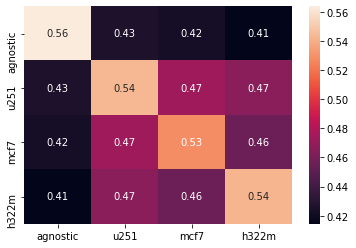

In [ ]:
plt.clf()
sns.heatmap(meanDiff_accOverlap_frac, 
        xticklabels=meanDiff_accOverlap_frac.columns,
        yticklabels=meanDiff_accOverlap_frac.columns,
        annot=True)
plt.savefig(workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/' + 'pPPIOverlap_bestPartition_specificModel+consensusHPA_cellSpecificPreds' + '.png', bbox_inches='tight')

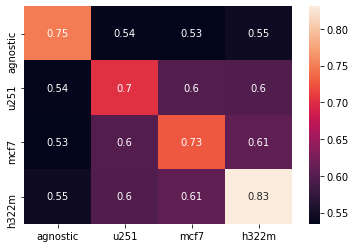

In [ ]:
plt.clf()
sns.heatmap(meanDiff_weightedOverlap_frac, 
        xticklabels=meanDiff_weightedOverlap_frac.columns,
        yticklabels=meanDiff_weightedOverlap_frac.columns,
        annot=True)
plt.savefig(workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/' + 'pPPIOverlap_weightedPartition_specificModel+consensusHPA_cellSpecificPreds' + '.png', bbox_inches='tight')